In [23]:
#!pip install tf-keras
#!pip install scikit-learn

In [24]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i=0

## NN creation and training

### Split the data into training and validation sets

In [25]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))
    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))

In [26]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(299, 299), batch_size=32, class_mode='binary', shuffle=False)

# Build the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# 2000 Elements
# load imagenet vgg to extract features
# Compile the model
# have mode one macpooling and conv2d

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 200 

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping,reduce_lr]   # Add the callbacks here
)

# Save the model after training
model.save('mask_detector_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

i+=1
i=0
# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 3274 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5242 - loss: 0.6979 - val_accuracy: 0.5281 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5272 - loss: 0.6726 - val_accuracy: 0.7775 - val_loss: 0.5124 - learning_rate: 0.0010
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6535 - loss: 0.5822 - val_accuracy: 0.9169 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7027 - loss: 0.5621 - val_accuracy: 0.8949 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7373 - loss: 0.5183 - val_accuracy: 0.8680 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7338 - loss: 0.5107 - val_accuracy: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.9715 - loss: 0.1098


Test Loss: 0.15045873820781708
Test Accuracy: 0.9437652826309204
Model trained and saved as 'mask_detector_model.h5'
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.9715 - loss: 0.1098
Test Loss: 0.15045873820781708
Test Accuracy: 0.9437652826309204


### Test the model on the test set

Load the model

In [27]:
## load the model
n = 0
model = tf.keras.models.load_model(f'mask_detector_model_{n}.h5')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 297, 297, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │       262,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,819 (1.23 MB)

 Trainable params: 322,817 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


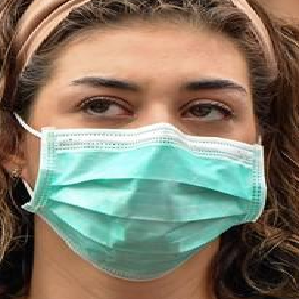

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


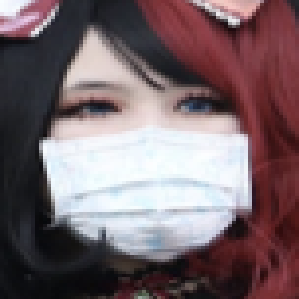

Image: w_mask_2.png_face_2.png - Prediction: Mask (0.01)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


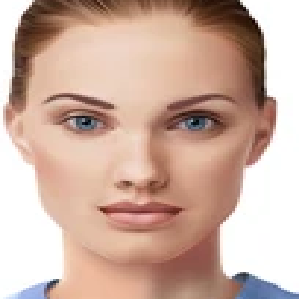

Image: test2.png_face_1.png - Prediction: No Mask (0.96)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


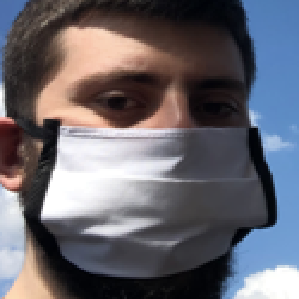

Image: w_mask_1.png_face_1.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


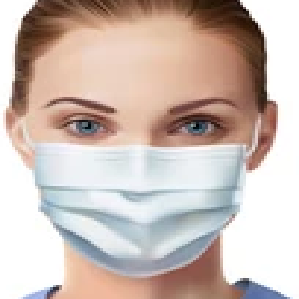

Image: test2.png_face_2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


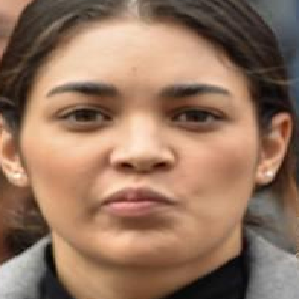

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


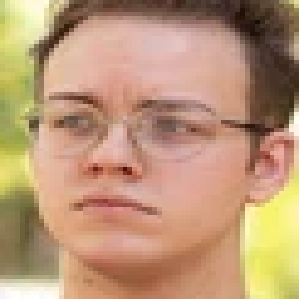

Image: test3.png_face_1.png - Prediction: No Mask (0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


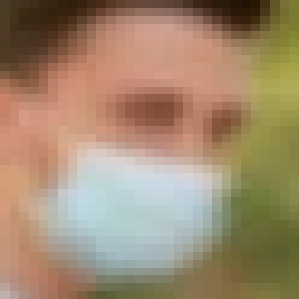

Image: test3.png_face_2.png - Prediction: Mask (0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


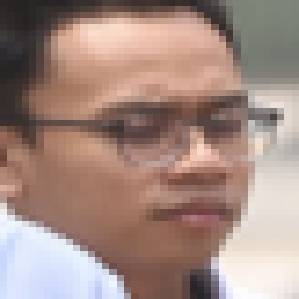

Image: mix_mask_2.png_face_2.png - Prediction: No Mask (0.89)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


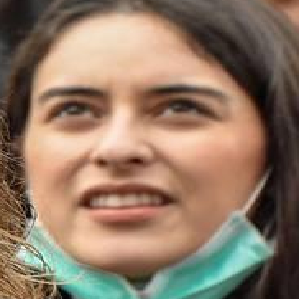

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (0.96)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


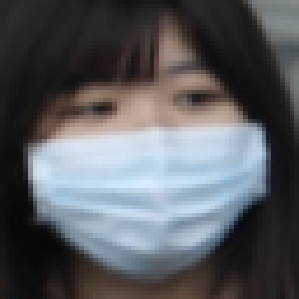

Image: w_mask_2.png_face_1.png - Prediction: Mask (0.01)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


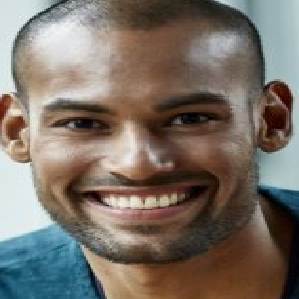

Image: test.jpg_face_1.png - Prediction: No Mask (0.87)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


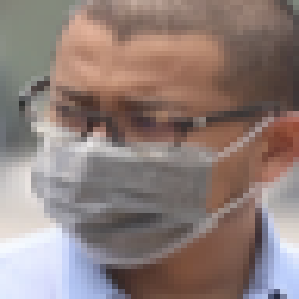

Image: mix_mask_2.png_face_1.png - Prediction: Mask (0.00)


In [28]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

# Function to make predictions on individual images
def predict_images(folder_path):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        # Load and preprocess the image
        img = load_img(image_path, target_size=(299, 299))  # Resize to match input size
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = model.predict(img_array)
        label = "Mask" if prediction[0][0] < 0.5 else "No Mask"
        display(img)
        print(f"Image: {image_name} - Prediction: {label} ({prediction[0][0]:.2f})")

# Call the function
predict_images(test_images_folder)
